**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)



Perceptron(random_state=42)

Saving figure perceptron_iris_plot


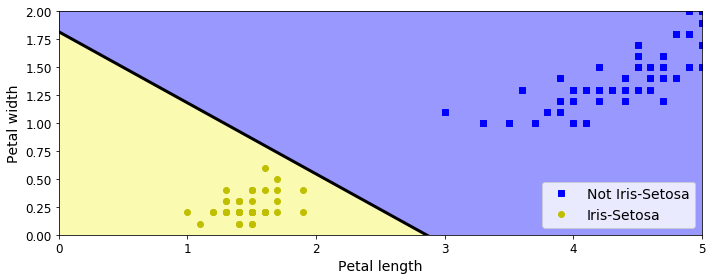

In [3]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


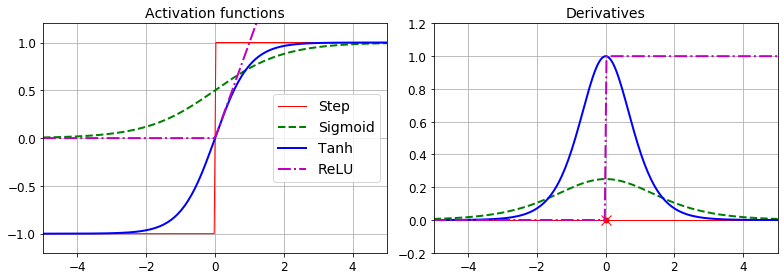

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.1.0'

In [8]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [10]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [11]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

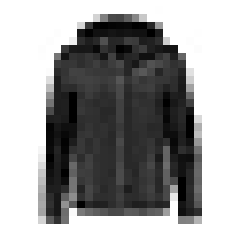

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [16]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [17]:
X_valid.shape

(5000, 28, 28)

In [18]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


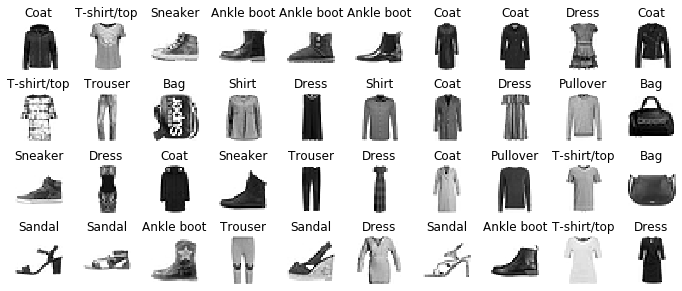

In [19]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [22]:
model.layers

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


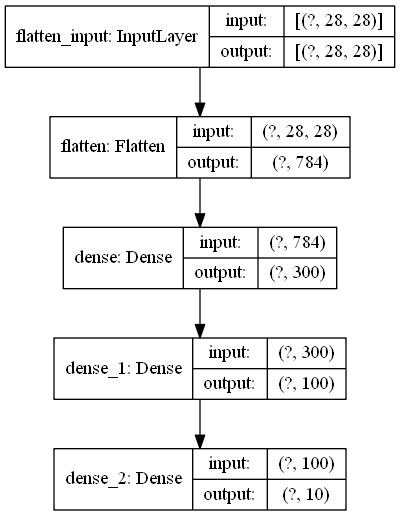

In [24]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [26]:
model.get_layer(hidden1.name) is hidden1

True

In [27]:
weights, biases = hidden1.get_weights()

In [28]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [29]:
weights.shape

(784, 300)

In [30]:
biases.shape

(300,)

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [32]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 65us/sample - loss: 0.7226 - accuracy: 0.7642 - val_loss: 0.5075 - val_accuracy: 0.8314
Epoch 2/30
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4843 - accuracy: 0.8321 - val_loss: 0.4538 - val_accuracy: 0.8486
Epoch 3/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.4413 - accuracy: 0.8465 - val_loss: 0.4385 - val_accuracy: 0.8490
Epoch 4/30
55000/55000 [==============================] - 3s 51us/sample - loss: 0.4128 - accuracy: 0.8549 - val_loss: 0.4163 - val_accuracy: 0.8562
Epoch 5/30
55000/55000 [==============================] - 3s 54us/sample - loss: 0.3926 - accuracy: 0.8617 - val_loss: 0.3817 - val_accuracy: 0.8636
Epoch 6/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.3770 - accuracy: 0.8667 - val_loss: 0.3729 - val_accuracy: 0.8680
Epoch 7/30
55000/55000 [==============================] -

In [33]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [34]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


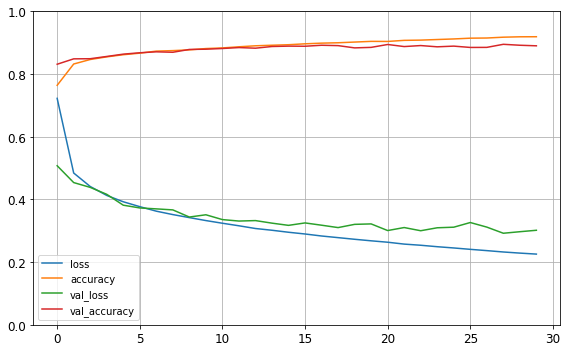

In [36]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [37]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 34us/sample - loss: 0.3348 - accuracy: 0.8788


[0.3347936288356781, 0.8788]

In [38]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [39]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [40]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [41]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


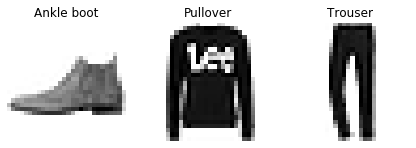

In [42]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [43]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 65us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5004 - val_l

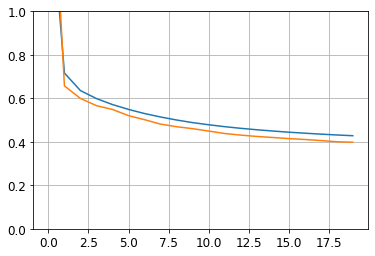

In [46]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [47]:
y_pred

array([[0.37310064],
       [1.6790789 ],
       [3.0817137 ]], dtype=float32)

# Saving and Restoring

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [50]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 73us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4576 - val_l

In [51]:
model.save("my_keras_model.h5")

In [52]:
model = keras.models.load_model("my_keras_model.h5")

In [53]:
model.predict(X_new)

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [54]:
model.save_weights("my_keras_weights.ckpt")

In [55]:
model.load_weights("my_keras_weights.ckpt")